# Matching Predictions with KNN

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import CelebA
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors

In [3]:
# define model architecture
class MultiLabelResNet(nn.Module):
    def __init__(self):
        super(MultiLabelResNet, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 40),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# instantiate
model = MultiLabelResNet()

# load WEIGHTS from saved model
model.load_state_dict(torch.load("CelebA_resnet18.pth", map_location=torch.device('cpu')))
model.eval()  # Set to evaluation mode 

print("model loaded successfully")

/home/ksg8xy/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ksg8xy/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


model loaded successfully


#### Load in dataset:

In [7]:
%%time

# define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor()
])

# load the CelebA dataset
######### SET download=True if you have never downloaded the data this way before. Each time after that set download=False ##########
train_dataset = CelebA(root='data', split='train', target_type='attr', download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

CPU times: user 9.43 s, sys: 407 ms, total: 9.84 s
Wall time: 9.7 s


#### Get attributes for all images (ground truth)

In [8]:
%%time

train_attrs = []

for _, labels in train_loader:
    train_attrs.append(labels)  # binary attributes

train_attrs = torch.cat(train_attrs).cpu().numpy().astype(int)

CPU times: user 24min 32s, sys: 14.4 s, total: 24min 47s
Wall time: 4min 40s


In [9]:
train_attrs.shape

(162770, 40)

#### View attribute names

In [10]:
import os

file_path = 'data/celeba/list_attr_celeba.txt'
with open(file_path, 'r') as f:
    lines = f.readlines()
attribute_names = lines[1].strip().split()

for i, name in enumerate(attribute_names):
    print(f"{i+1}: {name}")

1: 5_o_Clock_Shadow
2: Arched_Eyebrows
3: Attractive
4: Bags_Under_Eyes
5: Bald
6: Bangs
7: Big_Lips
8: Big_Nose
9: Black_Hair
10: Blond_Hair
11: Blurry
12: Brown_Hair
13: Bushy_Eyebrows
14: Chubby
15: Double_Chin
16: Eyeglasses
17: Goatee
18: Gray_Hair
19: Heavy_Makeup
20: High_Cheekbones
21: Male
22: Mouth_Slightly_Open
23: Mustache
24: Narrow_Eyes
25: No_Beard
26: Oval_Face
27: Pale_Skin
28: Pointy_Nose
29: Receding_Hairline
30: Rosy_Cheeks
31: Sideburns
32: Smiling
33: Straight_Hair
34: Wavy_Hair
35: Wearing_Earrings
36: Wearing_Hat
37: Wearing_Lipstick
38: Wearing_Necklace
39: Wearing_Necktie
40: Young


#### Initialize KNN model

In [11]:
# Initialize and fit KNN using the train_attrs (binary attributes of the images)
knn = NearestNeighbors(n_neighbors=5, metric='hamming')  # hamming for binary data
knn.fit(train_attrs)

NearestNeighbors(metric='hamming')

#### Test on image in test set

In [13]:
test_dataset = CelebA(root='data', split='test', target_type='attr', download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
test_dataset

Dataset CelebA
    Number of datapoints: 19962
    Root location: data
    Target type: ['attr']
    Split: test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Get all test predictions: 

In [16]:
%%time
model.eval()

all_outputs = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images 
        labels = labels.float()

        outputs = model(images)
        outputs = outputs 

        all_outputs.append(outputs)
        all_labels.append(labels)
        all_images.append(images)

all_outputs = torch.cat(all_outputs).cpu()
all_labels = torch.cat(all_labels).cpu()
all_images = torch.cat(all_images).cpu()

test_preds = (all_outputs >= 0.5).float()

mean_accuracy = (test_preds == all_labels).float().mean().item()
print(f"test set mean accuracy: {mean_accuracy:.4f}")

test set mean accuracy: 0.8988
CPU times: user 11min 23s, sys: 22.4 s, total: 11min 45s
Wall time: 2min 14s


In [17]:
test_preds

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.]])

In [18]:
test_preds.shape

torch.Size([19962, 40])

In [33]:
# Pred 0 KNN
query_attr = test_preds[0].numpy().reshape(1, -1)  # Convert to numpy array (1, 40)

# Get top 5 nearest neighbots
distances, indices = knn.kneighbors(query_attr, n_neighbors=5)
print(f"Indices of closest images: {indices}")

Indices of closest images: [[158150  40445 152530 114650  37192]]


In [34]:
import torchvision.transforms.functional as TF

def plot_image_from_dataset(dataset, idx):
    img, _ = dataset[idx]  # You can also grab the label if needed
    if isinstance(img, torch.Tensor):
        img = TF.to_pil_image(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Train Image {idx}")
    plt.show()

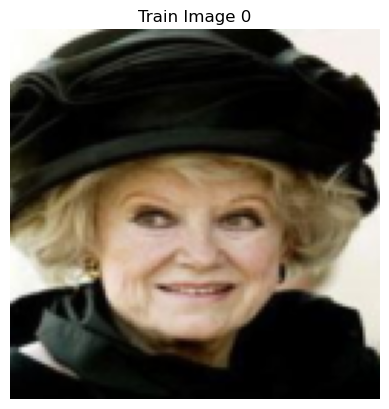

In [36]:
# Plot pred 0
plot_image_from_dataset(test_dataset, 0)

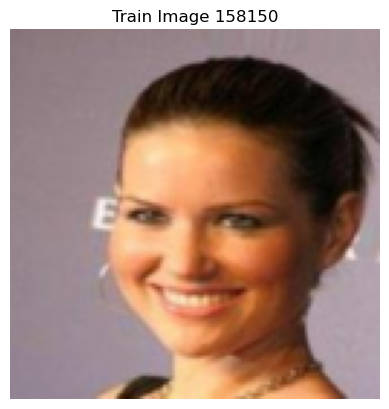

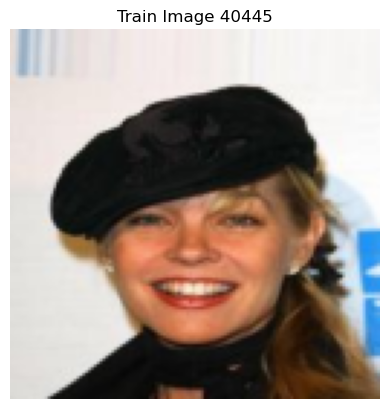

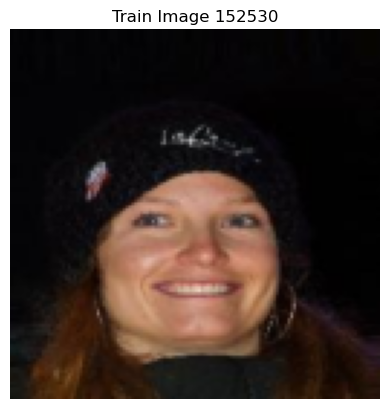

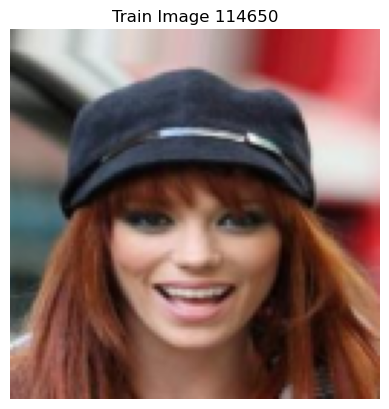

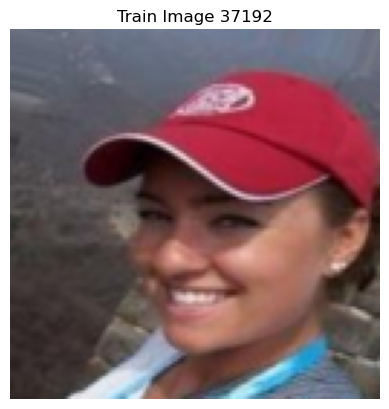

In [42]:
# Plot top 3 matches
for i in indices[0]:
    plot_image_from_dataset(train_dataset, i)

In [56]:
# Pred 0 KNN
query_attr = test_dataset[0][1].numpy().reshape(1, -1)  # Convert to numpy array (1, 40)

# Get top 5 nearest neighbots
distances, indices = knn.kneighbors(query_attr, n_neighbors=5)
print(f"Indices of closest images: {indices}")

Indices of closest images: [[ 29605 161370  39821  86398  62897]]


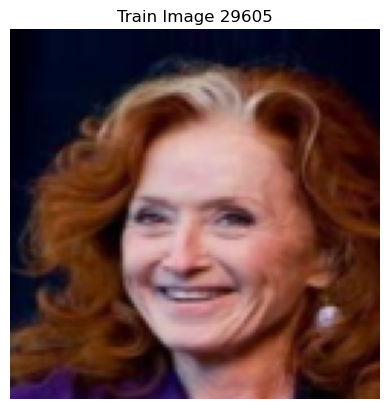

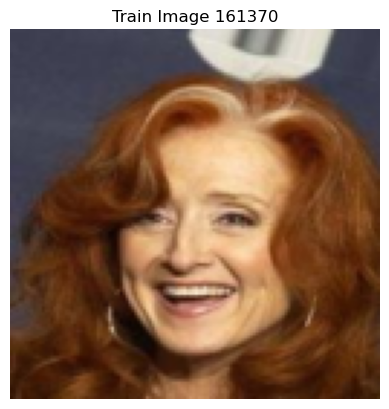

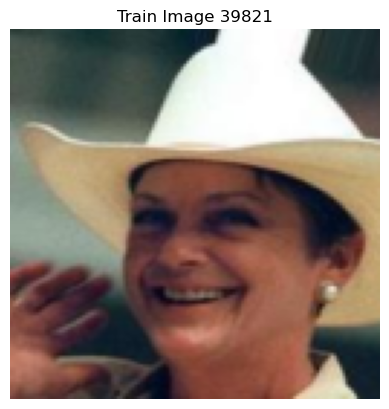

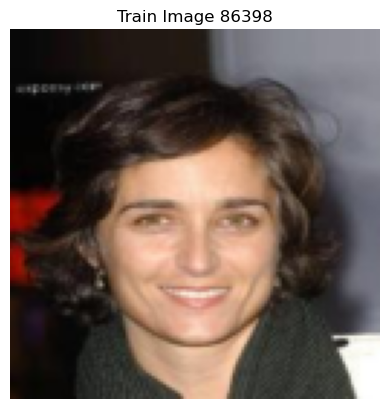

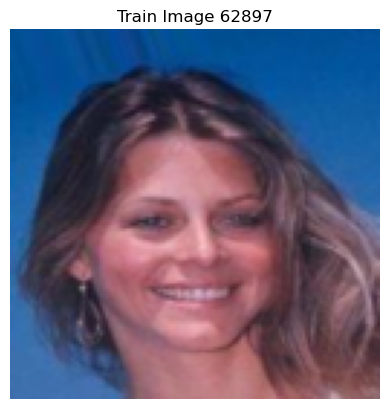

In [57]:
# Plot top 3 matches
for i in indices[0]:
    plot_image_from_dataset(train_dataset, i)

#### Load in Adam Brody image

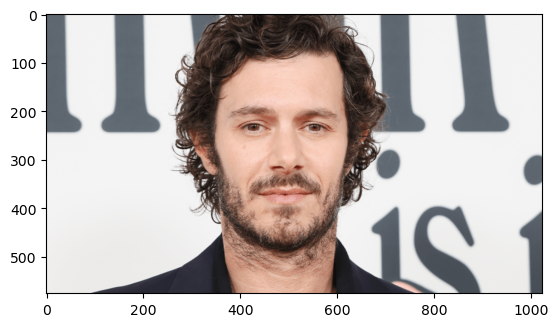

In [58]:
from PIL import Image
# Same transformation as celebA dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
image_path = "adam_brody.png"
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.show()
input_tensor = transform(image).unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(input_tensor)         # shape: [1, 40]
    pred = (output >= 0.5).float() 

In [59]:
pred

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

In [60]:
pred.shape

torch.Size([1, 40])

In [61]:
# Adam Brody KNN
query_attr = pred.numpy().reshape(1, -1)  # Convert to numpy array (1, 40)

# Get top 5 nearest neighbots
distances, indices = knn.kneighbors(query_attr, n_neighbors=5)
print(f"Indices of closest images: {indices}")

Indices of closest images: [[ 61955  89360  88991  63023 141604]]


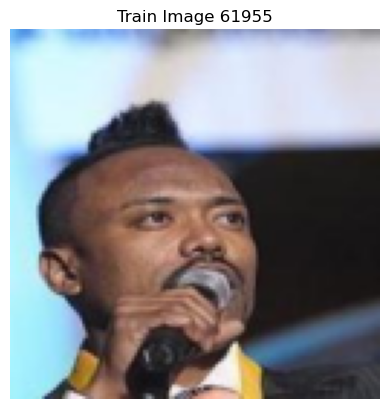

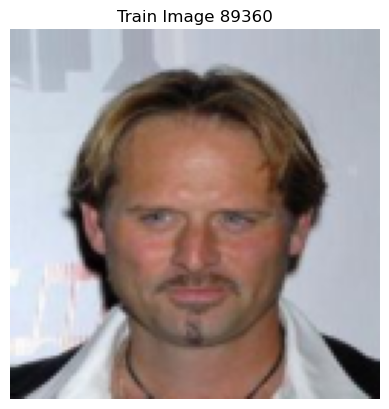

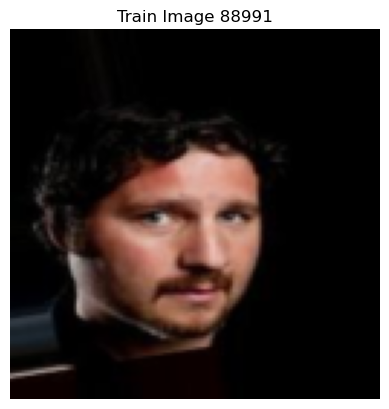

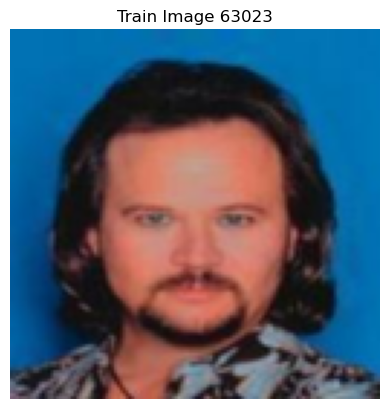

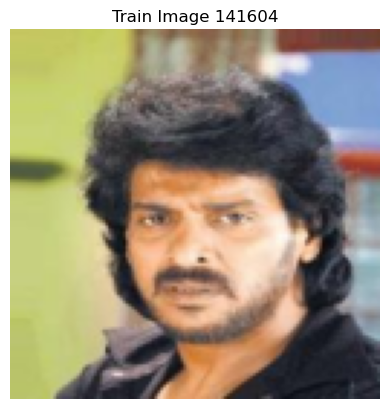

In [62]:
# Plot top 3 matches
for i in indices[0]:
    plot_image_from_dataset(train_dataset, i)

In [68]:
(train_dataset[61955][1] == pred).sum()

tensor(40)